# Terraform 


## 1. Import Libraries

In [13]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys

project_root = Path().resolve().parent.parent
if project_root not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added {project_root} to Python path")

import importlib
from src.analysis import diff_utils
importlib.reload(diff_utils)

from src.analysis.diff_utils import (
    load_all_commit_jsonl,
    parse_patch_to_dataframe,
    enrich_dataframe_with_terraform_semantics,
    get_other_lines,
)
        
from src.analysis.config import get_config
config = get_config()

DATASET_DIR = Path(config['dataset_dir'])
commits = load_all_commit_jsonl(DATASET_DIR)

2025-04-25 23:09:46,128 - terraform_diff_utils - INFO - Loading commits from directory: C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner\data\dataset


Added C:\Users\asu\OneDrive\Study\University\Studies\Disciplinas\last-one\lastonesemester\TCC\terraform-miner\terraform-miner to Python path


2025-04-25 23:09:46,316 - terraform_diff_utils - INFO - Total commits loaded: 21524
2025-04-25 23:09:46,316 - terraform_diff_utils - INFO -   Repository 100daysofdevops_100daysofdevops: 1 commits
2025-04-25 23:09:46,317 - terraform_diff_utils - INFO -   Repository alijahnas_CKA-practice-exercises: 1 commits
2025-04-25 23:09:46,318 - terraform_diff_utils - INFO -   Repository antonputra_tutorials: 1 commits
2025-04-25 23:09:46,318 - terraform_diff_utils - INFO -   Repository aws-ia_terraform-aws-eks-blueprints: 1 commits
2025-04-25 23:09:46,319 - terraform_diff_utils - INFO -   Repository Azure_terraform-azurerm-caf-enterprise-scale: 1 commits
2025-04-25 23:09:46,319 - terraform_diff_utils - INFO -   Repository bridgecrewio_terragoat: 1 commits
2025-04-25 23:09:46,319 - terraform_diff_utils - INFO -   Repository brikis98_terraform-up-and-running-code: 1 commits
2025-04-25 23:09:46,320 - terraform_diff_utils - INFO -   Repository chime_terraform-aws-alternat: 1 commits
2025-04-25 23:09:4

In [14]:
rows = []
for c in tqdm(commits, desc="Parsing patches"):
    df_patch = parse_patch_to_dataframe(c["patch"])
    df_patch["file"]   = c["file"]
    df_patch["repo"]   = c["repo"]
    df_patch["commit"] = c["commit_hash"]
    rows.append(df_patch)

all_df = pd.concat(rows, ignore_index=True)
all_df = all_df[all_df["file"].str.endswith(".tf", na=False)]

# Enriquecer com heurísticas simples (resource_type, attr_name…)
all_df = enrich_dataframe_with_terraform_semantics(all_df)


Parsing patches:   0%|          | 0/21524 [00:00<?, ?it/s]

C:\Users\asu\AppData\Local\Temp\ipykernel_86684\1478775931.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_df = pd.concat(rows, ignore_index=True)


2 · “Arquivos mais modificados” (quantidade de linhas tocadas)

Total de linhas com categoria 'other': 163546


,file,content
14520,examples/complete-kubernetes-addons/versions.tf,required_providers {
133253,fast/stages-multitenant/0-bootstrap-tenant/out...,"""${path.module}/templates/providers.tf.tpl..."
152941,fast/stages/2-networking-c-nva/net-landing.tf,"module ""landing-trusted-vpc"" {"
272644,examples/cloud-operations/network-dashboard/ma...,
379485,workers.tf,"""propagate_at_launch"" = true"
149645,blueprints/networking/__need_fixing/nginx-reve...,logging:
109645,fast/stages/1-resman/top-level-folders.tf,"for k, v in local.top_level_folders :"
186737,modules/kms/outputs.tf,google_kms_key_ring_iam_binding.bindings
426895,5-app-infra/modules/env_base/data.tf,* Unless required by applicable law or agreed...
121256,modules/gcs/iam.tf,"try(local._iam_principals[role], [])"


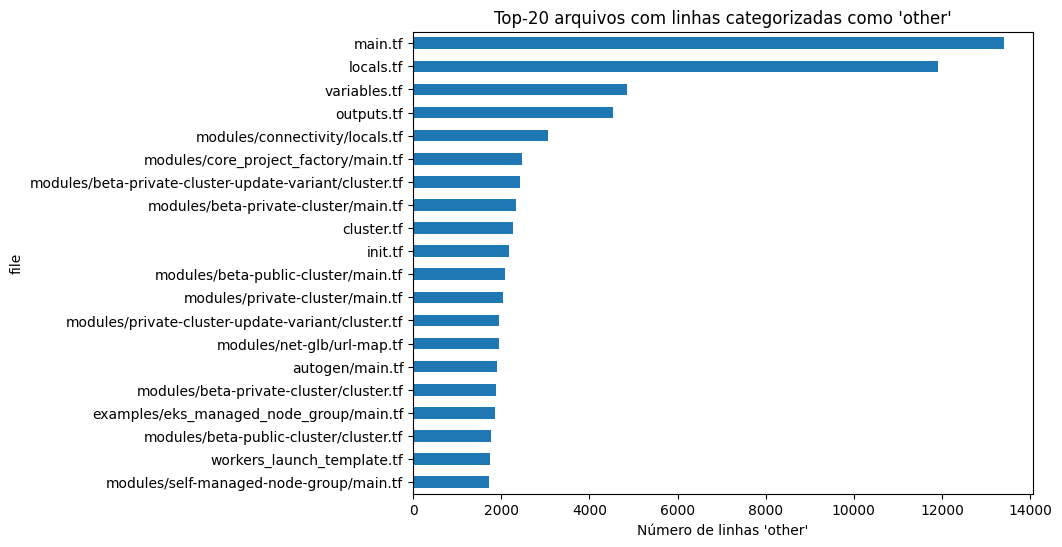

In [15]:

try:
    most_touched_files = (
        all_df.groupby("file")  
              .size()
              .sort_values(ascending=False)
              .head(20)
    )

    most_touched_files.plot(kind="barh", figsize=(6,6))
    plt.title("Top-20 arquivos Terraform mais modificados")
    plt.xlabel("Total de linhas em diffs")
    plt.gca().invert_yaxis()


    # 2.1 Linhas classificadas como 'other' para inspeção

    # Filtra apenas as linhas que ficaram com categoria 'other'
    other_df = get_other_lines(all_df)

    print(f"Total de linhas com categoria 'other': {len(other_df)}")

    # Top-20 arquivos com mais linhas 'other'
    top_other = (
        other_df
        .groupby("file")
        .size()
        .sort_values(ascending=False)
        .head(20)
    )

    top_other.plot(kind="barh", figsize=(8,6))
    plt.title("Top-20 arquivos com linhas categorizadas como 'other'")
    plt.xlabel("Número de linhas 'other'")
    plt.gca().invert_yaxis()

    # Amostra de algumas linhas 'other' para inspeção qualitativa
    display(other_df.sample(10, random_state=42)[["file","content"]])


except KeyError as e:
    print(f"KeyError: Column not found: {e}")
    print("Available columns:", all_df.columns.tolist())


In [16]:
     # 2.1 Breakdown of 'other' category
other_df = get_other_lines(all_df)
total = len(other_df)
print(f"Total 'other' lines: {total}")

# Heuristic subtypes
value_like     = other_df['content'].str.contains(r'\w+\s*=\s*').sum()
structure_like = other_df['content'].str.match(r'^\s*[{}\[\]]+\s*$').sum()
comment_like   = other_df['content'].str.strip().str.startswith('#').sum()
heredoc_like   = other_df['content'].str.contains('<<-').sum()
residual       = total - sum([value_like, structure_like, comment_like, heredoc_like])

print(f"  value-like:     {value_like}")
print(f"  structure-like: {structure_like}")
print(f"  comment-like:   {comment_like}")
print(f"  heredoc-like:   {heredoc_like}")
print(f"  residual:       {residual}")

# Show a few examples of each subtype
display(other_df[other_df['content'].str.contains(r'\w+\s*=\s*')].head(3))
display(other_df[other_df['content'].str.match(r'^\s*[{}\[\]]+\s*$')].head(3))
display(other_df[other_df['content'].str.strip().str.startswith('#')].head(3))
display(other_df[other_df['content'].str.contains('<<-')].head(3))
exclude_idx = (
    other_df[other_df['content'].str.contains(r'\w+\s*=\s*')].index
    .union(other_df[other_df['content'].str.match(r'^\s*[{}\[\]]+\s*$')].index)
    .union(other_df[other_df['content'].str.strip().str.startswith('#')].index)
    .union(other_df[other_df['content'].str.contains('<<-')].index)
)

display(other_df.loc[~other_df.index.isin(exclude_idx)].head(3))

Total 'other' lines: 163546
  value-like:     4306
  structure-like: 0
  comment-like:   22710
  heredoc-like:   55
  residual:       136475


,file,old_lineno,new_lineno,hunk_id,change,content,category,line_num,repo,commit,resource_type,resource_name,attr_name,attr_value
748,patterns/karpenter-mng/eks.tf,64.0,NaN,1,removed,"# cluster_tags = merge(local.tags, {",other,3.0,aws-ia_terraform-aws-eks-blueprints,1975b53c9ebe5f8dcde979ccdae3d87dcb5e43cd,None,None,None,None
2232,patterns/blue-green-upgrade/modules/eks_cluste...,NaN,54.0,1,added,"# description = ""debug output""",other,5.0,aws-ia_terraform-aws-eks-blueprints,32421b38b2b04d4282095594cb819369c4263216,None,None,None,None
2233,patterns/blue-green-upgrade/modules/eks_cluste...,NaN,55.0,1,added,# #value = data.template_file.addons_templat...,other,6.0,aws-ia_terraform-aws-eks-blueprints,32421b38b2b04d4282095594cb819369c4263216,None,None,None,None


,file,old_lineno,new_lineno,hunk_id,change,content,category,line_num,repo,commit,resource_type,resource_name,attr_name,attr_value


,file,old_lineno,new_lineno,hunk_id,change,content,category,line_num,repo,commit,resource_type,resource_name,attr_name,attr_value
290,patterns/multi-node-vllm/eks.tf,51.0,51.0,1,context,# The EKS AL2023 NVIDIA AMI provides al...,other,11.0,aws-ia_terraform-aws-eks-blueprints,edf44e0e11a5a9961972503c63c3e28daae82276,None,None,None,None
295,patterns/fargate-serverless/main.tf,146.0,NaN,1,removed,# Enable Fargate logging this may generate a...,other,3.0,aws-ia_terraform-aws-eks-blueprints,e6c38b1f947a204017d641ab33b799183778796b,None,None,None,None
296,patterns/fargate-serverless/main.tf,NaN,146.0,1,added,# Enable Fargate logging,other,4.0,aws-ia_terraform-aws-eks-blueprints,e6c38b1f947a204017d641ab33b799183778796b,None,None,None,None


,file,old_lineno,new_lineno,hunk_id,change,content,category,line_num,repo,commit,resource_type,resource_name,attr_name,attr_value
2406,patterns/elastic-fabric-adapter/main.tf,220.0,213.0,6,context,<<-EOT,other,93.0,aws-ia_terraform-aws-eks-blueprints,9e407f03a2454c1148cd90a1667e74ce8c142362,None,None,None,None
3111,examples/stateful/main.tf,173.0,NaN,3,removed,cat <<-EOF > /etc/profile.d/bootstrap.sh,other,46.0,aws-ia_terraform-aws-eks-blueprints,f645a75fa8625cc325b920306a508920b4bb06df,None,None,None,None
4434,modules/kubernetes-addons/karpenter/locals.tf,23.0,23.0,1,context,<<-EOT,other,7.0,aws-ia_terraform-aws-eks-blueprints,80811d4ad33a7fa2c207f3afab2c14b30ad7cab5,None,None,None,None


,file,old_lineno,new_lineno,hunk_id,change,content,category,line_num,repo,commit,resource_type,resource_name,attr_name,attr_value
3,jenkins-terraform-pipeline/ec2_pipeline/main.tf,4.0,4.0,1,context,,other,2.0,100daysofdevops_100daysofdevops,15d2a3175cc03176176f0f10dc2bd2517c75f475,None,None,None,None
4,jenkins-terraform-pipeline/ec2_pipeline/main.tf,NaN,5.0,1,added,,other,3.0,100daysofdevops_100daysofdevops,15d2a3175cc03176176f0f10dc2bd2517c75f475,None,None,None,None
12,jenkins-terraform-pipeline/ec2_pipeline/main.tf,9.0,10.0,1,context,\ No newline at end of file,other,11.0,100daysofdevops_100daysofdevops,15d2a3175cc03176176f0f10dc2bd2517c75f475,None,None,None,None


3 · “Categorias de mudança” (evidência p/ categorize_change_line)

In [17]:
# 3.1 Distribuição global

Text(0.5, 1.0, 'Distribuição global de categorias de mudança')

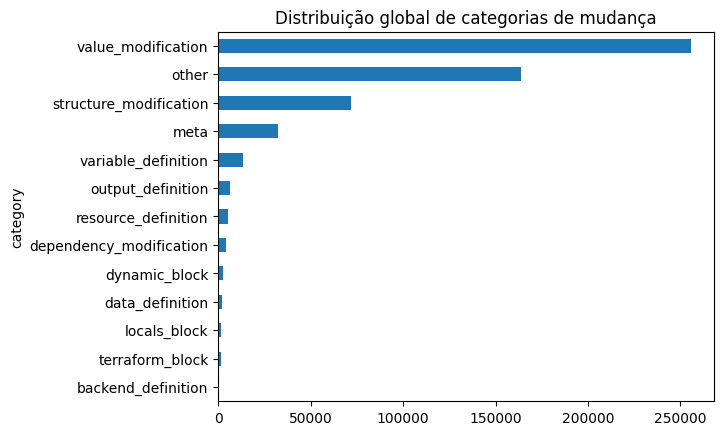

In [18]:
cats_global = all_df["category"].value_counts().sort_values()
cats_global.plot(kind="barh")
plt.title("Distribuição global de categorias de mudança")


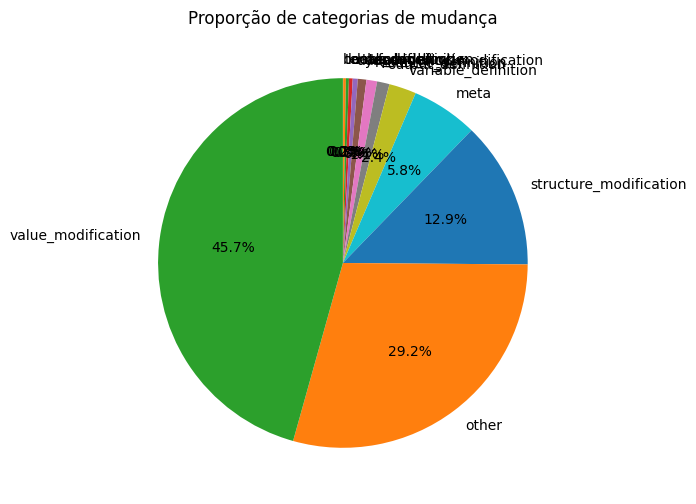

In [19]:
plt.figure(figsize=(6,6))
cats_global.plot(kind='pie', autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Proporção de categorias de mudança")
plt.ylabel("")
plt.show()

In [20]:
summary = cats_global.rename_axis('category').reset_index(name='count')
summary['pct'] = summary['count'] / summary['count'].sum() * 100
display(summary.style.format({'count':'{:,}','pct':'{:.1f}%'}))

,category,count,pct
0,backend_definition,144,0.0%
1,terraform_block,"1,317",0.2%
2,locals_block,"1,466",0.3%
3,data_definition,"1,834",0.3%
4,dynamic_block,"2,475",0.4%
5,dependency_modification,"4,181",0.7%
6,resource_definition,"5,217",0.9%
7,output_definition,"6,081",1.1%
8,variable_definition,"13,345",2.4%
9,meta,"32,502",5.8%


3.2 Frequência por repositório

Text(0.5, 1.0, 'Heatmap de categorias × repositório')

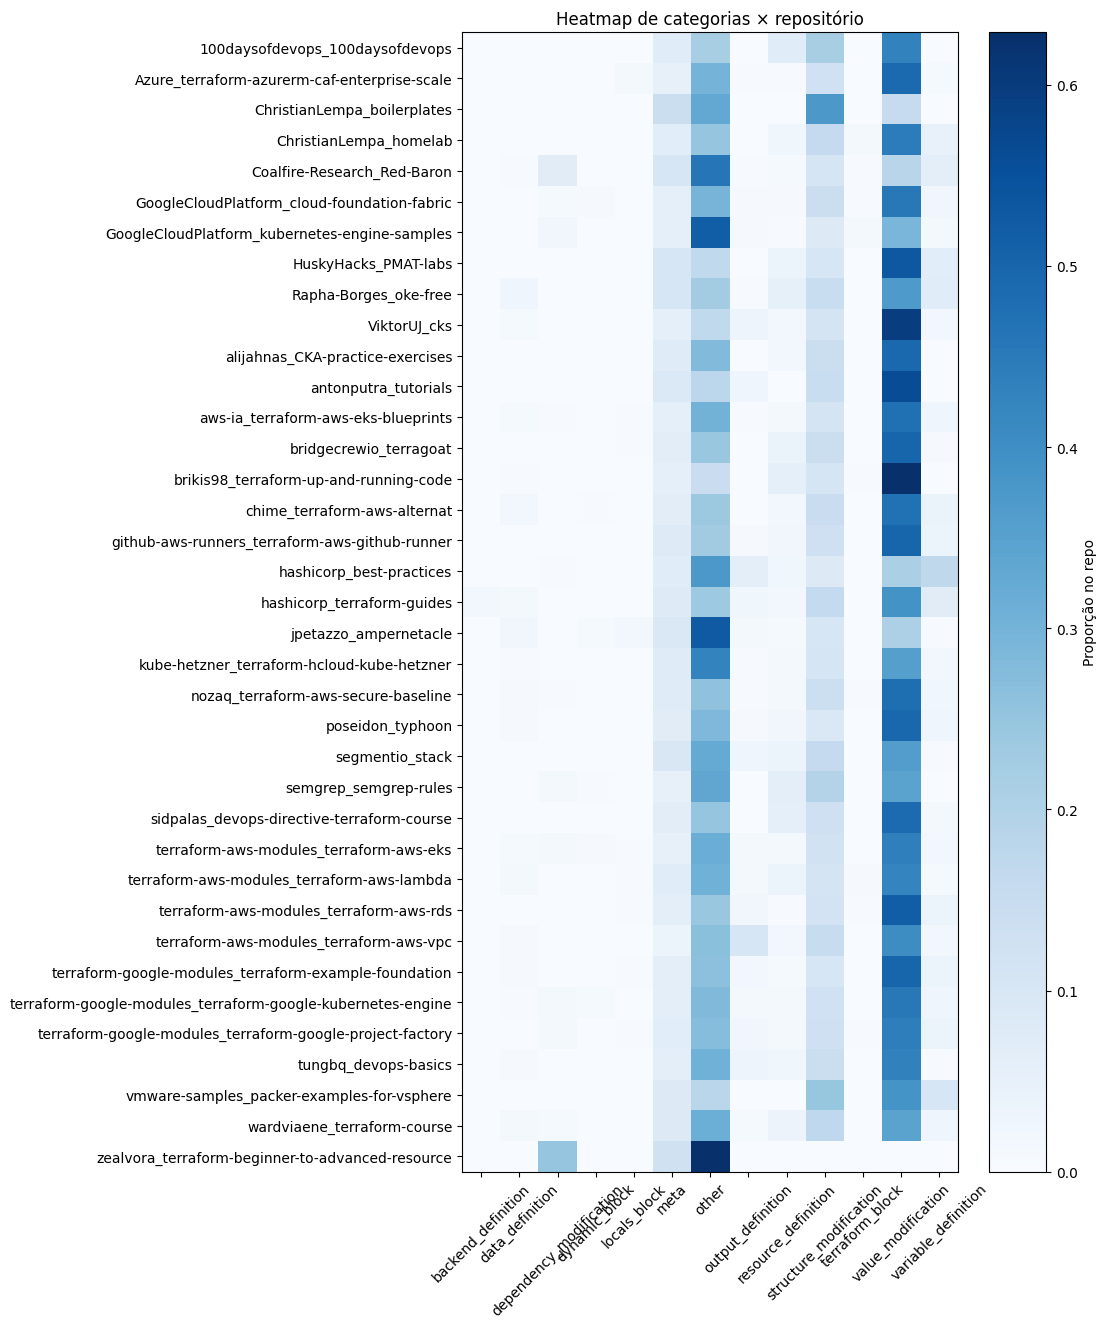

In [21]:
heat = (
    all_df.pivot_table(index="repo",
                       columns="category",
                       values="line_num",  # qualquer col numeric serve
                       aggfunc="count",
                       fill_value=0)
)
heat = heat[heat.sum(axis=1) > 0]          # remove repositórios vazios
heat_div = heat.div(heat.sum(axis=1), axis=0)  # normaliza %

plt.figure(figsize=(8, 0.4*len(heat)))
plt.imshow(heat_div, aspect="auto", cmap="Blues")
plt.yticks(range(len(heat)), heat.index)
plt.xticks(range(len(heat.columns)), heat.columns, rotation=45)
plt.colorbar(label="Proporção no repo")
plt.title("Heatmap de categorias × repositório")


4 · “Linhas classificadas como other” → ponto de melhoria

In [22]:
unknown_df = all_df[all_df["category"] == "other"]
display(unknown_df.sample(20, random_state=42)[["file", "content"]])


,file,content
14520,examples/complete-kubernetes-addons/versions.tf,required_providers {
133253,fast/stages-multitenant/0-bootstrap-tenant/out...,"""${path.module}/templates/providers.tf.tpl..."
152941,fast/stages/2-networking-c-nva/net-landing.tf,"module ""landing-trusted-vpc"" {"
272644,examples/cloud-operations/network-dashboard/ma...,
379485,workers.tf,"""propagate_at_launch"" = true"
149645,blueprints/networking/__need_fixing/nginx-reve...,logging:
109645,fast/stages/1-resman/top-level-folders.tf,"for k, v in local.top_level_folders :"
186737,modules/kms/outputs.tf,google_kms_key_ring_iam_binding.bindings
426895,5-app-infra/modules/env_base/data.tf,* Unless required by applicable law or agreed...
121256,modules/gcs/iam.tf,"try(local._iam_principals[role], [])"


5 · “Recursos & atributos mais frequentes” (p/ inspirar operadores)

Text(0.5, 1.0, 'Atributos mais alterados (top-15)')

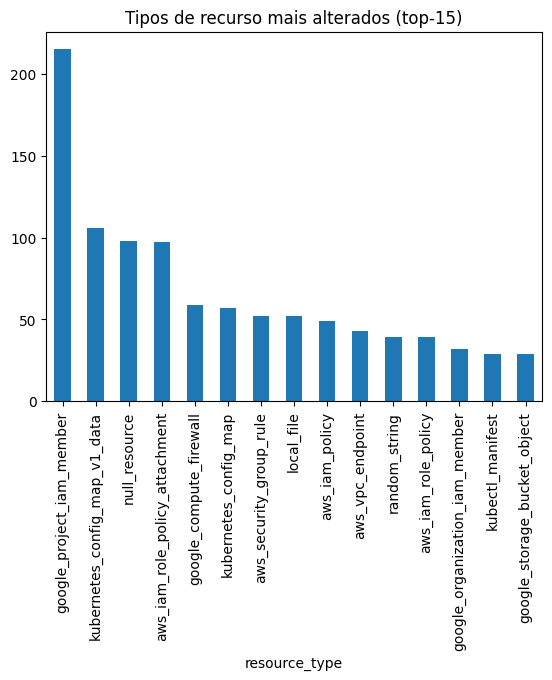

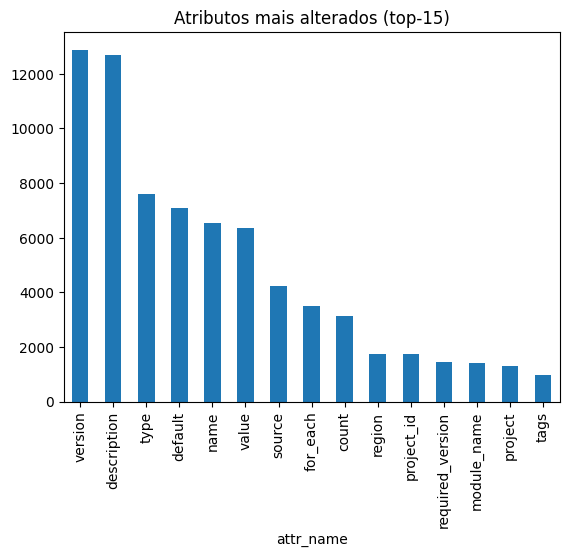

In [23]:
# Recurso criado pela heurística simples de enrich_dataframe_with_terraform_semantics
top_resources = (
    all_df["resource_type"]
         .dropna()
         .value_counts()
         .head(15)
)
top_resources.plot(kind="bar")
plt.title("Tipos de recurso mais alterados (top-15)")

top_attrs = (
    all_df["attr_name"]
         .dropna()
         .value_counts()
         .head(15)
)
plt.figure()
top_attrs.plot(kind="bar")
plt.title("Atributos mais alterados (top-15)")
